# G3 Processing

This file contains code to view and load G3 files produced by ``g3_packager``.

To run this Jupyter notebook on the CCAT Control Computer, see [``HOWTORUN.md``](./HOWTORUN.md).

## G3 File Analysis

In [2]:
import so3g
from spt3g import core
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import EarthLocation, SkyCoord
import astropy.units
import os

In [3]:
control_computer_g3_dir = "/media/player1/blast2020fc1/blasttng_g3"
path_to_file = "testing/roach1_pass3.g3"
filename = os.path.join(control_computer_g3_dir, path_to_file)

### File Content Overview

In [69]:
class FrameCounter(core.G3Module):
    def __init__(self):
        super(FrameCounter, self).__init__()
        self.previous_type = None
        self.num_repeats = 0
    def Process(self, frame):
        type = frame.type
        if type == self.previous_type:
            self.num_repeats += 1
            print(f"{type} (x{self.num_repeats + 1})", end='\r')
        else:
            print()
            print(f"{type}", end='\r')
            if type == core.G3FrameType.EndProcessing: print()
            self.num_repeats = 0
        self.previous_type = type

In [4]:
pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=filename)
pipe.Add(FrameCounter)
pipe.Run()


Calibration
PipelineInfo
Scan (x117)
EndProcessing


### File Content Full Dump

In [5]:
pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=filename)
pipe.Add(core.Dump)
pipe.Run()

Frame (Calibration) [
"target_sweeps" (spt3g.core.G3TimestreamMap) => Timestreams from 1143 detectors
]
Frame (PipelineInfo) [
"04-Apr-2025:19:40:14.836693000" (spt3g.core.G3PipelineInfo) => UNKNOWN VCS branch, local diffs
"05-Apr-2025:00:18:02.902811000" (spt3g.core.G3PipelineInfo) => UNKNOWN VCS branch, local diffs
]
Frame (Scan) [
"alt" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"az" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"data" (so3g.G3SuperTimestream) => G3SuperTimestream(762, 1428)
"el" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"lat" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"lon" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"time" (spt3g.core.G3Time) => 04-Apr-2025:19:40:14.835471000
]
Frame (Scan) [
"alt" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"az" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"data" (so3g.G3SuperTimestream) => G3SuperTimestream(762, 1428)
"el" (spt3g.core.G3Timestream) => 1428 sa

### Scan Frames

In [4]:
class FirstFrameGrabber:
    """Stores the first frame of a given type"""
    def __init__(self, frame_type: core.G3FrameType=None):
        self.frame_type = frame_type if frame_type is not None else core.G3FrameType.Scan
        self.first_frame = None
    def __call__(self, frame):
        if self.first_frame is not None:
            # already found the frame
            return
        if frame.type == self.frame_type:
            self.first_frame = frame
            print(f"Found the first frame with type: {self.frame_type}!")
            print(f"The frame is now stored in {self}'s first_frame attribute.")
            return
class LastFrameGrabber:
    """Grabs the last frame of a given type"""
    def __init__(self, frame_type: core.G3FrameType=None):
        self.frame_type = frame_type if frame_type is not None else core.G3FrameType.Scan
        self.last_frame = None
    def __call__(self, frame):
        if frame.type == self.frame_type:
            self.last_frame = frame
            return
        if frame.type == core.G3FrameType.EndProcessing:
            print(f"Found the last frame with type: {self.frame_type}!")
            print(f"The frame is now stored in {self}'s last_frame attribute.")

In [5]:
first_scan_grabber = FirstFrameGrabber(core.G3FrameType.Scan)
last_scan_grabber = LastFrameGrabber(core.G3FrameType.Scan)

pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=filename)
pipe.Add(first_scan_grabber)
pipe.Add(last_scan_grabber)
pipe.Run()

first_scan_frame = first_scan_grabber.first_frame
last_scan_frame = last_scan_grabber.last_frame

print("\nFirst Scan Frame: ", first_scan_frame)
print("\nLast Scan Frame: ", last_scan_frame)

Found the first frame with type: Scan!
The frame is now stored in <__main__.FirstFrameGrabber object at 0x7fb4a9a4a950>'s first_frame attribute.
Found the last frame with type: Scan!
The frame is now stored in <__main__.LastFrameGrabber object at 0x7fb4a9a4ac80>'s last_frame attribute.

First Scan Frame:  Frame (Scan) [
"alt" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"az" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"data" (so3g.G3SuperTimestream) => G3SuperTimestream(762, 1428)
"el" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"lat" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"lon" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"time" (spt3g.core.G3Time) => 04-Apr-2025:19:40:14.835471000
]

Last Scan Frame:  Frame (Scan) [
"alt" (spt3g.core.G3Timestream) => 935 samples at 473.1 Hz
"az" (spt3g.core.G3Timestream) => 935 samples at 473.1 Hz
"data" (so3g.G3SuperTimestream) => G3SuperTimestream(762, 935)
"el" (spt3g.core.G3Timestream) => 935 s

### Calibration Frame

In [6]:
calframe_grabber = FirstFrameGrabber(core.G3FrameType.Calibration)

pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=filename)
pipe.Add(calframe_grabber)
pipe.Run()

cal_frame = calframe_grabber.first_frame

print("\nCalibration Frame: ", cal_frame)

Found the first frame with type: Calibration!
The frame is now stored in <__main__.FirstFrameGrabber object at 0x7fb4a9a4b220>'s first_frame attribute.

Calibration Frame:  Frame (Calibration) [
"target_sweeps" (spt3g.core.G3TimestreamMap) => Timestreams from 1143 detectors
]


In [9]:
# Here is how to load targ_sweeps info for DF calculation

If_0000 = np.array(cal_frame["target_sweeps"]["roach1_0000_I"])
Qf_0000 = np.array(cal_frame["target_sweeps"]["roach1_0000_Q"])
Ff_0000 = np.array(cal_frame["target_sweeps"]["roach1_0000_F"])

for name, arr in zip(("If", "Qf", "Ff"), (If_0000, Qf_0000, Ff_0000)):
    print(f"{name}.shape: ", arr.shape)

# If, Qf, and Ff are required inputs to df_IQangle, in addition to the KID I/Q data

If.shape:  (176,)
Qf.shape:  (176,)
Ff.shape:  (176,)


### RA/DEC Computation

We can now compute RA/DEC from the stored information, add "ra" and "dec" as keys in the scan frame, and save the result of the pipeline to a new file.

In [10]:
def add_radec(frame, az: str="az", el: str="el", lat: str="lat", lon: str="lon", alt: str="alt", data: str="data",
             ra: str="ra", dec: str="dec"):
    """Use astropy coordinate transformations to convert az/el --> ra/dec.

    Keyword arguments indicate keys in the scan frame for inputs/outputs
    Requires lat/lon/alt to determine the telescope location as an input to astropy.coordinates.SkyCoord
    """
    if frame.type != core.G3FrameType.Scan:
        return
    
    az_deg = np.array(frame[az]) / core.G3Units.deg
    el_deg = np.array(frame[el]) / core.G3Units.deg
    lat_deg = np.array(frame[lat]) / core.G3Units.deg
    lon_deg = np.array(frame[lon]) / core.G3Units.deg
    alt_m = np.array(frame[alt]) / core.G3Units.m

    unix_times = np.array(frame[data].times) / core.G3Units.s
    times = astropy.time.Time(unix_times, format="unix")

    blasttng_loc = EarthLocation(lat=lat_deg, lon=lon_deg, height=alt_m)
    sky_coords = SkyCoord(alt=el_deg*astropy.units.deg,
                                              az=az_deg*astropy.units.deg,
                                              obstime=times,
                                              frame='altaz',
                                              location=blasttng_loc)
    t_i = frame[data].times[0]
    t_f = frame[data].times[-1]
    
    ra_ts = core.G3Timestream(sky_coords.icrs.ra.deg * core.G3Units.deg)
    ra_ts.start = t_i
    ra_ts.stop = t_f
    frame[ra] = ra_ts

    dec_ts = core.G3Timestream(sky_coords.icrs.dec.deg * core.G3Units.deg)
    dec_ts.start = t_i
    dec_ts.stop = t_f
    frame[dec] = dec_ts


In [7]:
radec_file = os.path.join(control_computer_g3_dir, "testing/add_radec.g3")

In [ ]:
pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=filename)
pipe.Add(add_radec)
pipe.Add(core.G3Writer, filename=radec_file)
pipe.Run(profile=True)

In [12]:
def plot_ra_dec(frame):
    # skip any frame that doesn't contain the right key
    if "ra" not in frame or "dec" not in frame:
        return

    # plot coordinates in real units
    plt.plot(frame["ra"] / core.G3Units.deg, frame["dec"] / core.G3Units.deg)

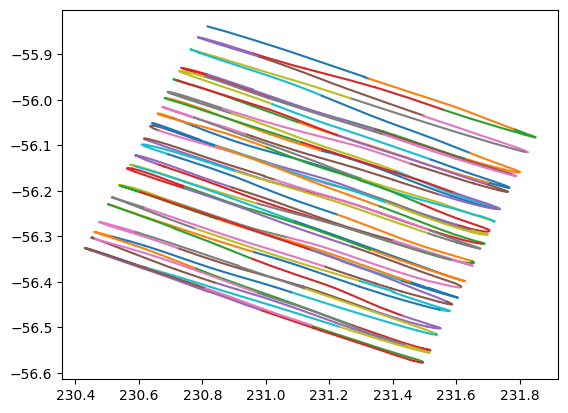

In [13]:
pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=radec_file)
pipe.Add(plot_ra_dec)
pipe.Run()

### DF Calculation

#### Single Detector

In [73]:
from data_loader import data_lib as dlib

def df_IQangle(I, Q, If, Qf, Ff, i_f0=None):
    '''Calculate df using IQ Angle Method.
    
    I: (1D array of floats) Timestream S21 real component.
    Q: (1D array of floats) Timestream S21 imaginary component.
    If: (1D array of floats) Target sweep S21 real component.
    Qf: (1D array of floats) Target sweep S21 imaginary component.
    Ff: (1D array of floats) Target sweep S21 frequency axis.
    '''
    
    if i_f0 is None:                        # resonant frequency index
        i_f0 = np.argmin(np.abs(If + 1j*Qf)) 
    
    cI = (If.max() + If.min())/2            # centre of target IQ loop
    cQ = (Qf.max() + Qf.min())/2
    
    # target sweep
    If_c, Qf_c = If - cI, Qf - cQ           # shift center to origin
    θf = np.arctan2(Qf_c, If_c)             # find IQ angles
    
    # observations
    I_c, Q_c = I - cI, Q - cQ               # shift origin
    θ = np.arctan2(Q_c, I_c)                # find IQ angles
    
    # adjust frequencies for delta from f0
    Ff0 = Ff - Ff[i_f0]                     # center Ff on f0
    
    # interpolate
    df = np.interp(θ, θf, Ff0, period=2*np.pi)
    
    return df/Ff[i_f0]

class AddSingleKidDF:
    def __init__(self, roach_id=1, kid="0000"):
        self.roach_id = roach_id
        self.kid = kid
        self.calframe = None

    def __call__(self, frame):
        if frame.type == core.G3FrameType.Calibration:
            self.calframe = frame
        if frame.type != core.G3FrameType.Scan:
            return
        assert self.calframe is not None, "failed to process scan frame: missing prior calibration frame!"

        # load I and Q
        ts: so3g.G3SuperTimestream = frame["data"]
        i_idx = int(np.where(np.asarray(ts.names) == f"roach{self.roach_id}_{self.kid}_I")[0][0])
        q_idx = int(np.where(np.asarray(ts.names) == f"roach{self.roach_id}_{self.kid}_Q")[0][0])
        kid_i = ts.data[i_idx]
        kid_q = ts.data[q_idx]
    
        # load target sweeps
        If = np.array(self.calframe["target_sweeps"][f"roach{self.roach_id}_{self.kid}_I"])
        Qf = np.array(self.calframe["target_sweeps"][f"roach{self.roach_id}_{self.kid}_Q"])
        Ff = np.array(self.calframe["target_sweeps"][f"roach{self.roach_id}_{self.kid}_F"])
        
        # build df tod
        df_tod = df_IQangle(kid_i, kid_q, If, Qf, Ff)

        t_i = frame["data"].times[0]
        t_f = frame["data"].times[-1]

        df_ts = core.G3Timestream(df_tod)
        df_ts.start = t_i
        df_ts.stop = t_f
        frame[f"roach{self.roach_id}_{self.kid}_DF"] = df_ts

In [8]:
single_df_file = os.path.join(control_computer_g3_dir, "testing/add_single_df.g3")

In [ ]:
pipe = core.G3Pipeline()

pipe.Add(core.G3Reader, filename=radec_file)
pipe.Add(AddSingleKidDF, roach_id=1, kid="0000")
pipe.Add(core.Dump)
pipe.Add(core.G3Writer, filename=single_df_file)

pipe.Run()

Frame (Calibration) [
"target_sweeps" (spt3g.core.G3TimestreamMap) => Timestreams from 1143 detectors
]
Frame (PipelineInfo) [
"04-Apr-2025:19:40:14.836693000" (spt3g.core.G3PipelineInfo) => UNKNOWN VCS branch, local diffs
"05-Apr-2025:00:18:03.469223000" (spt3g.core.G3PipelineInfo) => UNKNOWN VCS branch, local diffs
"05-Apr-2025:00:23:21.656005000" (spt3g.core.G3PipelineInfo) => UNKNOWN VCS branch, local diffs
]
Frame (Scan) [
"alt" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"az" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"data" (so3g.G3SuperTimestream) => G3SuperTimestream(762, 1428)
"dec" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"el" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"lat" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"lon" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"ra" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"roach1_0000_DF" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"time" (spt3g.co

In [9]:
scan_frame_grabber = FirstFrameGrabber(core.G3FrameType.Scan)

pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=single_df_file)
pipe.Add(scan_frame_grabber)
pipe.Run()

first_scan_frame = scan_frame_grabber.first_frame

print("\nFirst Scan Frame: ", first_scan_frame)

Found the first frame with type: Scan!
The frame is now stored in <__main__.FirstFrameGrabber object at 0x7fb4a9a497b0>'s first_frame attribute.

First Scan Frame:  Frame (Scan) [
"alt" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"az" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"data" (so3g.G3SuperTimestream) => G3SuperTimestream(762, 1428)
"dec" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"el" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"lat" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"lon" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"ra" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"roach1_0000_DF" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"time" (spt3g.core.G3Time) => 04-Apr-2025:19:40:14.835471000
]


In [63]:
class GenericPlotter:
    def __init__(self, array_getter=None, label: str=None, subplots_args: dict=None, plot_args: dict=None):
        """array_getter is a callable which takes in a frame and returns an array-like object to plot"""
        assert array_getter is not None, "GenericPlotter was not given an array_getter"
        self.array_getter = array_getter
        self.timestreams: list[np.ndarray] = []
        self.label = label if label is not None else self.array_getter.__name__
        self.subplots_args = subplots_args if subplots_args is not None else {}
        self.plot_args = plot_args if plot_args is not None else {}
    def __call__(self, frame):
        if frame.type == core.G3FrameType.EndProcessing:
            flatts: np.ndarray = np.concatenate(self.timestreams, axis=0).flatten()
            fig, ax = plt.subplots(**self.subplots_args)
            ax.plot(flatts, **self.plot_args)
            ax.set_xlabel("index")
            ax.set_ylabel(self.label)
            ax.set_title(self.label + " vs. index")
            plt.show()
        if frame.type != core.G3FrameType.Scan:
            return
        self.timestreams.append(self.array_getter(frame))

class TimeStreamPlotter(GenericPlotter):
    def __init__(self, ts_key=None, label: str=None, subplots_args: dict=None, plot_args: dict=None):
        assert ts_key is not None, "TimeStreamPlotter was not given a ts_key"
        self.ts_key = ts_key
        def timestream_array_getter(frame):
            return np.array(frame[self.ts_key])
        super().__init__(timestream_array_getter, label=label, subplots_args=subplots_args, plot_args=plot_args)

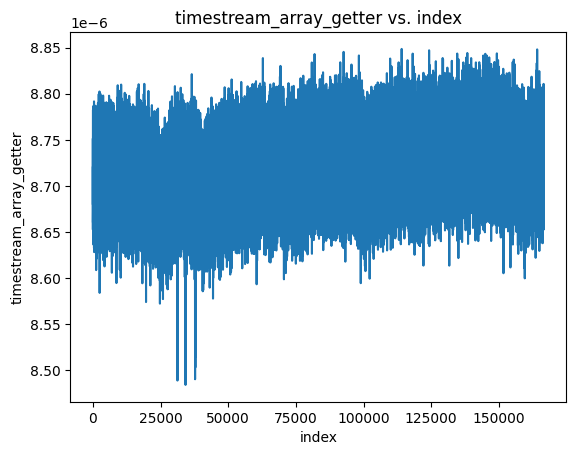

In [64]:
pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=single_df_file)
pipe.Add(TimeStreamPlotter, ts_key="roach1_0000_DF")
pipe.Run()

#### All Detectors

In [66]:
class AddAllDF:
    def __init__(self, roach_id=1):
        self.roach_id = roach_id
        self.calframe = None

    def __call__(self, frame):
        if frame.type == core.G3FrameType.Calibration:
            self.calframe = frame
        if frame.type != core.G3FrameType.Scan:
            return
        assert self.calframe is not None, "failed to process scan frame: missing prior calibration frame!"

        # get an arbitrarily ordered list of unique kids from calframe keys
        kids: list[str] = list({key[7:11] for key in self.calframe["target_sweeps"].keys()})

        # inputs to G3SuperTimestream constructor
        times: core.G3VectorTime = frame["data"].times  # same timestamps as I/Q data
        names: list[str] = []
        df_data: np.ndarray = np.zeros(shape=(len(kids), len(times)))
        
        for i, kid in enumerate(kids):
            # load I and Q
            ts: so3g.G3SuperTimestream = frame["data"]
            i_idx = int(np.where(np.asarray(ts.names) == f"roach{self.roach_id}_{kid}_I")[0][0])
            q_idx = int(np.where(np.asarray(ts.names) == f"roach{self.roach_id}_{kid}_Q")[0][0])
            kid_i = ts.data[i_idx]
            kid_q = ts.data[q_idx]
            # load target sweeps
            If = np.array(self.calframe["target_sweeps"][f"roach{self.roach_id}_{kid}_I"])
            Qf = np.array(self.calframe["target_sweeps"][f"roach{self.roach_id}_{kid}_Q"])
            Ff = np.array(self.calframe["target_sweeps"][f"roach{self.roach_id}_{kid}_F"])
            # build df tod and update names/df_data
            df_data[i] = df_IQangle(kid_i, kid_q, If, Qf, Ff)
            names.append(f"roach{self.roach_id}_{kid}")

        compressed_resolution = 10000
        quanta: np.ndarray[float] = ((np.abs(df_data).max() / compressed_resolution) 
                                      * np.ones(len(kids)))
        
        # add the G3SuperTimestream to the scan frame
        df_super_timestream = so3g.G3SuperTimestream(names, times, df_data, quanta)
        frame["df"] = df_super_timestream

In [67]:
all_df_file = os.path.join(control_computer_g3_dir, "testing/add_all_df.g3")

In [74]:
pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=radec_file)
pipe.Add(AddAllDF, roach_id=1)
pipe.Add(FrameCounter)
pipe.Add(core.G3Writer, filename=all_df_file)
pipe.Run()


Calibration
PipelineInfo
Scan (x117)
EndProcessing


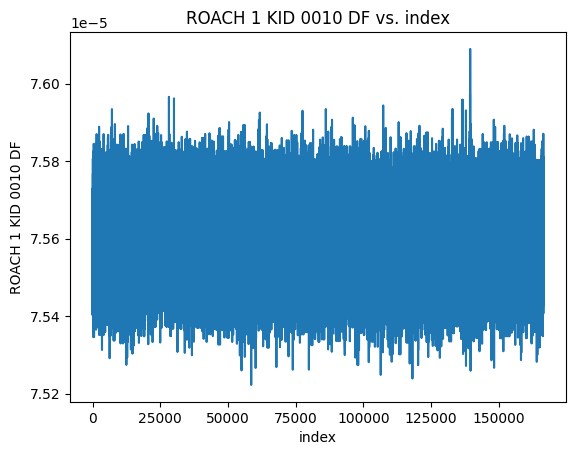

In [75]:
pipe = core.G3Pipeline()

def kid_df_getter(kid: str):
    def get_selected_kid_df(frame):
        kid_key = f"roach1_{kid}"
        super_ts = frame["df"]
        kid_idx = int(np.where(np.array(super_ts.names) == kid_key)[0][0])
        return np.array(super_ts.data[kid_idx])
    return get_selected_kid_df

kid_to_plot = "0010"
pipe.Add(core.G3Reader, filename=all_df_file)
pipe.Add(GenericPlotter, array_getter=kid_df_getter(kid_to_plot), label=f"ROACH 1 KID {kid_to_plot} DF")
pipe.Run()

In [71]:
def remove_common_mode(frame):
    # skip frames that don't contain the input key
    if "df" not in frame:
        return

    # get the input timestream data
    ts_in: core.G3SuperTimestream = frame["df"]

    # use broadcast to remove common-mode from all timestreams
    tsarr: np.ndarray[np.f64] = ts_in.data
    common_mode = np.mean(tsarr, axis=0)
    out_arr = tsarr - common_mode

    # create output object with correct timestamps and units
    df_ctremoved = so3g.G3SuperTimestream(ts_in.names, ts_in.times, out_arr, ts_in.quanta)

    # save the common mode as well
    common_mode = core.G3Timestream(common_mode)
    common_mode.start = ts_in.times[0]
    common_mode.stop = ts_in.times[-1]

    # store the calibrated timestreams to the output key in the frame
    frame["df_ctremoved"] = df_ctremoved
    frame["common_mode"] = common_mode

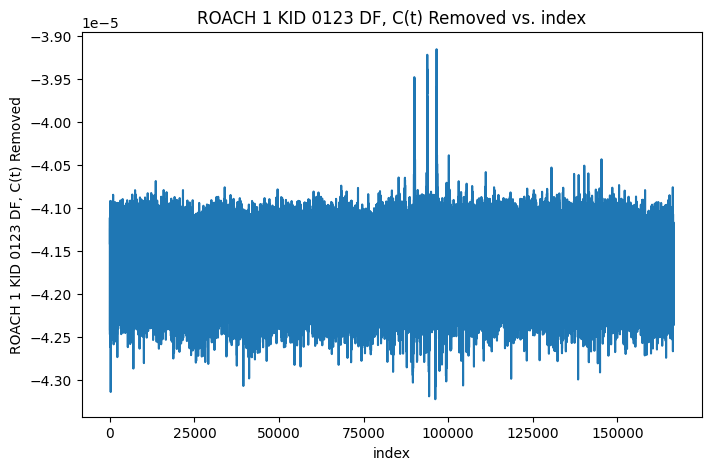

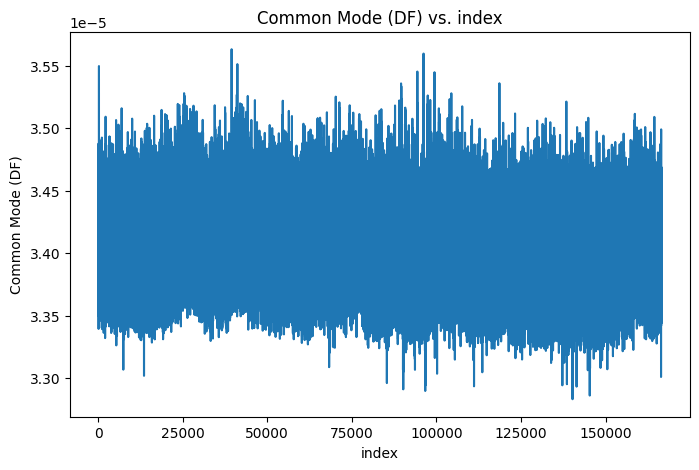

In [81]:
pipe = core.G3Pipeline()

def kid_df_ctremoved_getter(kid: str):
    def get_selected_kid_df(frame):
        kid_key = f"roach1_{kid}"
        super_ts = frame["df_ctremoved"]
        kid_idx = int(np.where(np.array(super_ts.names) == kid_key)[0][0])
        return np.array(super_ts.data[kid_idx])
    return get_selected_kid_df

kid_to_plot = "0123"
pipe.Add(core.G3Reader, filename=all_df_file)
pipe.Add(remove_common_mode)
pipe.Add(GenericPlotter,
         array_getter=kid_df_ctremoved_getter(kid_to_plot),
         label=f"ROACH 1 KID {kid_to_plot} DF, C(t) Removed",
         subplots_args={"figsize": (8, 5)})
pipe.Add(TimeStreamPlotter,
         label=f"Common Mode (DF)",
         ts_key="common_mode",
         subplots_args={"figsize": (8, 5)})
pipe.Run()